# Results

## 0. Import packages and data

In [1]:
# Beginning of code

In [2]:
# Change directory to import our functions

import os
os.chdir('../2_modeling/')
from discovery_real_data import Chen, LLR, UCB1

In [21]:
# Load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cmath import inf
from tqdm import tqdm
import matplotlib.patches as mpatches

In [4]:
report = pd.read_csv(r"../../Data/matriz_eventos_real.csv", sep = ";").drop(columns = ["celda", "Localidad", "Rep. Rate"]).values
preport = pd.read_csv(r"../../Data/matriz_eventos_subreporte.csv", sep = ";").drop(columns = ["celda", "Localidad", "Rep. Rate"]).values
diccionario_localidades = pd.read_csv(r"../../Data/matriz_eventos_real.csv", sep = ";")[["celda", "Localidad"]]
celdas = diccionario_localidades.celda.unique()
filtro0 = report.any(axis = 1)
report = report[filtro0,]
preport = preport[filtro0,]
diccionario_localidades = diccionario_localidades.loc[filtro0,]
celdas = diccionario_localidades.celda.unique()

In [5]:
# Definimos la semilla para la replicabilidad del código
np.random.seed(123)

## 1. Initialize our models and define the parameters

In [6]:
# Número de cuadrantes
M = report.shape[0]
# Cantidad de brazos (o policías)
K = int(M * .1)
# Períodos de tiempo
T_max = report.shape[1]
# Probabilidad de observar el crimen perfectamente en los cuadrantes no visitados
p = 0
# Media del crimen por cudrante
# Ahora vamos a encontrar rho que es la probabilidad de éxito de nuestra binomial
# N puede ser cualquier cosa pero dejamos un número interpretable
N = 1000

# Construimos q_real como el promedio del subreporte por cuadrante
q_real_viejo = np.mean(preport, axis = 1)/np.mean(report, axis = 1)
rho = np.median(report, axis=1) / N
q_real = (np.array([np.sum(preport[i][report[i] != 0] / report[i][report[i] != 0]) for i in range(report.shape[0])]) / report.shape[1]) 

In [7]:
chen = Chen(M, K, N, report, preport)
llr = LLR(M, K, N, report, preport, underreporting=False)
ucb1 =  UCB1(M, K, N, report, preport)

In [8]:
distances_mu = pd.DataFrame(index = np.arange(T_max))
distances_q = pd.DataFrame(index = np.arange(T_max))
iterative_distances = pd.DataFrame(index = np.arange(T_max), columns = ['UCB1', 'LLR', 'CUCB'])

## 2.1. UCB1

In [9]:
# Total number of times arm i is played so far
T_i = np.zeros(M)

# Mean outcomes

X_T = np.zeros((T_max, M))

S_T = np.zeros((T_max, M))

historical_mu_hat = np.zeros((T_max, M))

mu_hat = ucb1.initialization(T_i)

historical_q_hat =  np.zeros((T_max, M))
for t in range(T_max):
    t += 1

    # save historical mu_hat's
    historical_mu_hat[t - 1] = mu_hat
    q_temp = np.ma.array(X_T[:t], mask = S_T[:t].astype(bool)).mean(axis=0).data

    cond_temp = mu_hat == 0
    historical_q_hat[t - 1][cond_temp] = 0
    historical_q_hat[t - 1][~cond_temp] = (q_temp[~cond_temp] / (mu_hat[~cond_temp])) * (1 - (1 - mu_hat[~cond_temp])**N)
    # historical_q_hat[t - 1][historical_q_hat[t - 1] == inf] = 0
    
    #oracle 
    a = ucb1.oracle(mu_hat, t, T_i)

    # 0-index
    S_T[t - 1] = a
    T_i[a.astype(bool)] += 1
    
    # update m_hat, t_i
    mu_hat = ucb1.update_mu_hat(X_T, a, t, S_T)

    iterative_distances.loc[t - 1, 'UCB1'] = np.linalg.norm((historical_mu_hat[t - 1] - mu_hat) / (historical_mu_hat[t - 1] + 1e-9))

distances_mu['UCB1'] = np.linalg.norm(historical_mu_hat - np.tile(rho, (T_max, 1)), axis=1)
distances_q['UCB1'] = np.linalg.norm(historical_q_hat - np.tile(q_real, (T_max, 1)), axis=1)

In [10]:
mu_hat_final = pd.DataFrame(historical_mu_hat).reset_index().rename(columns = {"index": "t"}) \
    .melt(id_vars = "t").rename(columns = {"variable": "m"}).assign(model = "UCB1")

In [11]:
historical_q_hat_ucb1 = historical_q_hat.copy()

In [12]:
underreporting_ucb1 = pd.concat([pd.DataFrame({"celda": celdas, "m": mu_hat_final.m.unique()}) \
    .merge(diccionario_localidades, how = "left", on = "celda"), 
    pd.DataFrame((N*historical_mu_hat*historical_q_hat).T)], axis = 1)
underreporting_ucb1.to_csv('../../Outputs/Data/underreporting_ucb1.csv', sep = ";", index = False)

reporting_ucb1 = pd.concat([pd.DataFrame({"celda": celdas, "m": mu_hat_final.m.unique()}) \
    .merge(diccionario_localidades, how = "left", on = "celda"), 
    pd.DataFrame((N*historical_mu_hat).T)], axis = 1)
reporting_ucb1.to_csv('../../Outputs/Data/reporting_ucb1.csv', sep = ";", index = False)

In [13]:
underreporting1 = pd.DataFrame((N*historical_mu_hat*historical_q_hat).sum(axis = 1)).reset_index() \
    .rename(columns = {"index": "t", 0: "underreporting"}).assign(algorithm = "UCB1")
reporting1 = pd.DataFrame((N*historical_mu_hat).sum(axis = 1)).reset_index() \
    .rename(columns = {"index": "t", 0: "underreporting"}).assign(algorithm = "UCB1")

## 2.2. Learning with Linear Rewards (LLR)

In [14]:
# Total number of times arm i is played so far
T_i = np.zeros(M)

# Mean outcomes

X_T = np.zeros((T_max, M))

S_T = np.zeros((T_max, M))

historical_mu_hat = np.zeros((T_max, M))

mu_hat = llr.initialization(T_i)

historical_q_hat =  np.zeros((T_max, M))

for t in range(T_max):
    t += 1

    # save historical mu_hat's
    historical_mu_hat[t - 1] = mu_hat

    q_temp = np.ma.array(X_T[:t], mask=S_T[:t].astype(bool)).mean(axis=0).data

    cond_temp = mu_hat == 0
    historical_q_hat[t - 1][cond_temp] = 0
    historical_q_hat[t - 1][~cond_temp] = q_temp[~cond_temp] / (mu_hat[~cond_temp]) * (1 - (1 - mu_hat[~cond_temp])**N)
    # historical_q_hat[t - 1][~cond_temp][historical_q_hat[t - 1][~cond_temp] == inf] = 0

    #oracle
    a = llr.oracle(mu_hat, t, T_i)

    # 0-index
    S_T[t - 1] = a
    T_i[a.astype(bool)] += 1
    
    # update m_hat, t_i
    mu_hat = llr.update_mu_hat(X_T, a, t, S_T)
    iterative_distances.loc[t - 1, 'LLR'] = np.linalg.norm((historical_mu_hat[t - 1] - mu_hat) / (historical_mu_hat[t - 1] + 1e-9))

distances_mu['LLR'] = np.linalg.norm(historical_mu_hat - np.tile(rho, (T_max, 1)), axis=1)
distances_q['LLR'] = np.linalg.norm(historical_q_hat - np.tile(q_real, (T_max, 1)), axis=1)

In [15]:
mu_hat_final = pd.concat([mu_hat_final, pd.DataFrame(historical_mu_hat).reset_index().rename(columns = {"index": "t"}) \
    .melt(id_vars = "t").rename(columns = {"variable": "m"}).assign(model = "LLR")])

In [16]:
historical_q_hat_llr = historical_q_hat.copy()

In [17]:
underreporting_llr = pd.concat([pd.DataFrame({"celda": celdas, "m": mu_hat_final.m.unique()}) \
    .merge(diccionario_localidades, how = "left", on = "celda"), 
    pd.DataFrame((N*historical_mu_hat*historical_q_hat).T)], axis = 1)
underreporting_llr.to_csv('../../Outputs/Data/underreporting_llr.csv', sep = ";", index = False)

reporting_llr = pd.concat([pd.DataFrame({"celda": celdas, "m": mu_hat_final.m.unique()}) \
    .merge(diccionario_localidades, how = "left", on = "celda"), 
    pd.DataFrame((N*historical_mu_hat).T)], axis = 1)
reporting_llr.to_csv('../../Outputs/Data/reporting_llr.csv', sep = ";", index = False)

In [18]:
underreporting2 = pd.DataFrame((N*historical_mu_hat*historical_q_hat).sum(axis = 1)).reset_index() \
    .rename(columns = {"index": "t", 0: "underreporting"}).assign(algorithm = "LLR")
reporting2 = pd.DataFrame((N*historical_mu_hat).sum(axis = 1)).reset_index() \
    .rename(columns = {"index": "t", 0: "underreporting"}).assign(algorithm = "LLR")

## 2.3. CUCB

In [19]:
# Total number of times arm i is played so far
T_i = np.zeros(M)

# Mean outcomes
mu_hat = np.ones(M)

X_T = np.zeros((T_max, M))

S_T = np.zeros((T_max, M))

historical_mu_hat = np.zeros((T_max, M))

historical_mu_bar = np.zeros((T_max, M))
historical_q_hat =  np.zeros((T_max, M))

for t in range(T_max):
    t += 1

    # save historical mu_hat's
    historical_mu_hat[t - 1] = mu_hat
    q_temp = np.ma.array(X_T[:t], mask=S_T[:t].astype(bool)).mean(axis=0).data

    cond_temp = mu_hat == 0
    historical_q_hat[t - 1][cond_temp] = 0
    historical_q_hat[t - 1][~cond_temp] = q_temp[~cond_temp] / (mu_hat[~cond_temp])* (1 - (1 - mu_hat[~cond_temp])**N)
    # historical_q_hat[t - 1][~cond_temp][historical_q_hat[t - 1][~cond_temp] == inf] = 0
    
    # update rule
    mu_bar = chen.update_rule(t, mu_hat, T_i)
    historical_mu_bar[t - 1] = mu_bar
    
    #oracle
    S = chen.oracle(mu_bar)

    # 0-index
    S_T[t - 1] = S
    T_i[S.astype(bool)] += 1
    
    # update m_hat, t_i
    mu_hat = chen.update_mu_hat_t_i(S, X_T, t, S_T)
    iterative_distances.loc[t - 1, 'Chen'] = np.linalg.norm((historical_mu_hat[t - 1] - mu_hat) / (historical_mu_hat[t - 1] + 1e-9))

distances_mu['CUCB'] = np.linalg.norm(historical_mu_hat - np.tile(rho, (T_max, 1)), axis=1)    
distances_q['CUCB'] = np.linalg.norm(historical_q_hat - np.tile(q_real, (T_max, 1)), axis=1)

In [20]:
historical_q_hat_cucb = historical_q_hat.copy()

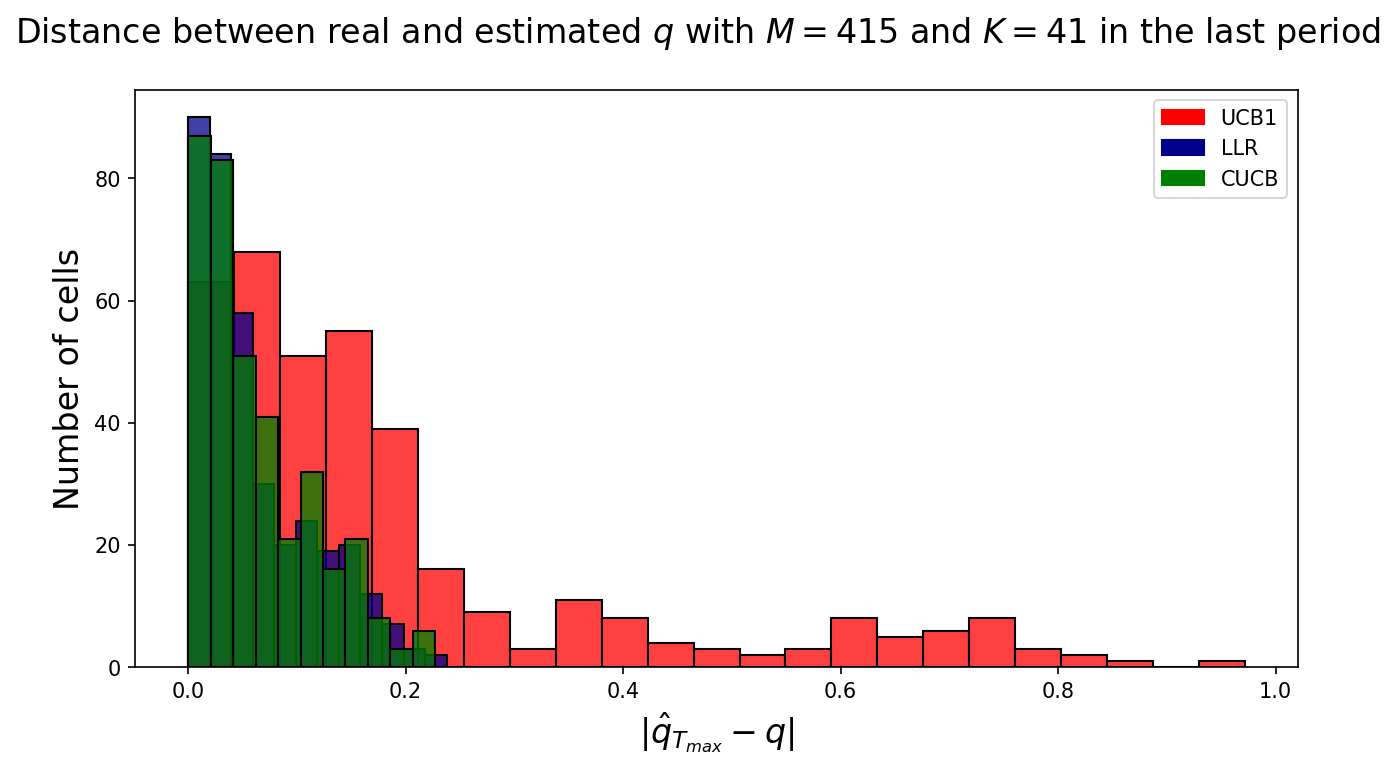

In [22]:
fig, ax = plt.subplots(figsize = (10, 5), dpi = 150)
sns.histplot(x = np.abs(historical_q_hat_ucb1[-1, rho != 0] - q_real[rho != 0]), ax = ax, color = "red")
sns.histplot(x = np.abs(historical_q_hat_llr[-1, rho != 0] - q_real[rho != 0]), ax = ax, color = "darkblue")
sns.histplot(x = np.abs(historical_q_hat_cucb[-1, rho != 0] - q_real[rho != 0]), ax = ax, color = "green")
ax.set_xlabel(r'$|\hat{q}_{T_{max}} - q|$', fontsize = 16);
ax.set_ylabel(r'Number of cells', fontsize = 16);

red_patch = mpatches.Patch(color = 'red', label = 'UCB1')
blue_patch = mpatches.Patch(color = 'darkblue', label = 'LLR')
green_patch = mpatches.Patch(color = 'green', label = 'CUCB')
plt.legend(handles=[red_patch, blue_patch, green_patch])

plt.savefig("../../Outputs/Figures/figure_12_convergencia_global_q_ultimo_periodo_notitulo2.png")
plt.suptitle(r'Distance between real and estimated $q$ with $M = {}$ and $K={}$ in the last period'.format(M, K), fontsize = 16);
plt.savefig("../../Outputs/Figures/figure_12_convergencia_global_q_ultimo_periodo2.png")

In [23]:
mu_hat_final = pd.concat([mu_hat_final, pd.DataFrame(historical_mu_hat).reset_index().rename(columns = {"index": "t"}) \
    .melt(id_vars = "t").rename(columns = {"variable": "m"}).assign(model = "CUCB")])

In [24]:
underreporting_cucb = pd.concat([pd.DataFrame({"celda": celdas, "m": mu_hat_final.m.unique()}) \
    .merge(diccionario_localidades, how = "left", on = "celda"), 
    pd.DataFrame((N*historical_mu_hat*historical_q_hat).T)], axis = 1)
underreporting_cucb.to_csv('../../Outputs/Data/underreporting_cucb.csv', sep = ";", index = False)

reporting_cucb = pd.concat([pd.DataFrame({"celda": celdas, "m": mu_hat_final.m.unique()}) \
    .merge(diccionario_localidades, how = "left", on = "celda"), 
    pd.DataFrame((N*historical_mu_hat).T)], axis = 1)
reporting_cucb.to_csv('../../Outputs/Data/reporting_cucb.csv', sep = ";", index = False)

In [25]:
underreporting3 = pd.DataFrame((N*historical_mu_hat*historical_q_hat).sum(axis = 1)).reset_index() \
    .rename(columns = {"index": "t", 0: "underreporting"}).assign(algorithm = "CUCB")
reporting3 = pd.DataFrame((N*historical_mu_hat).sum(axis = 1)).reset_index() \
    .rename(columns = {"index": "t", 0: "underreporting"}).assign(algorithm = "CUCB")

In [26]:
distances_q["Steps"] = range(1, T_max + 1)
distances_mu["Steps"] = range(1, T_max + 1)

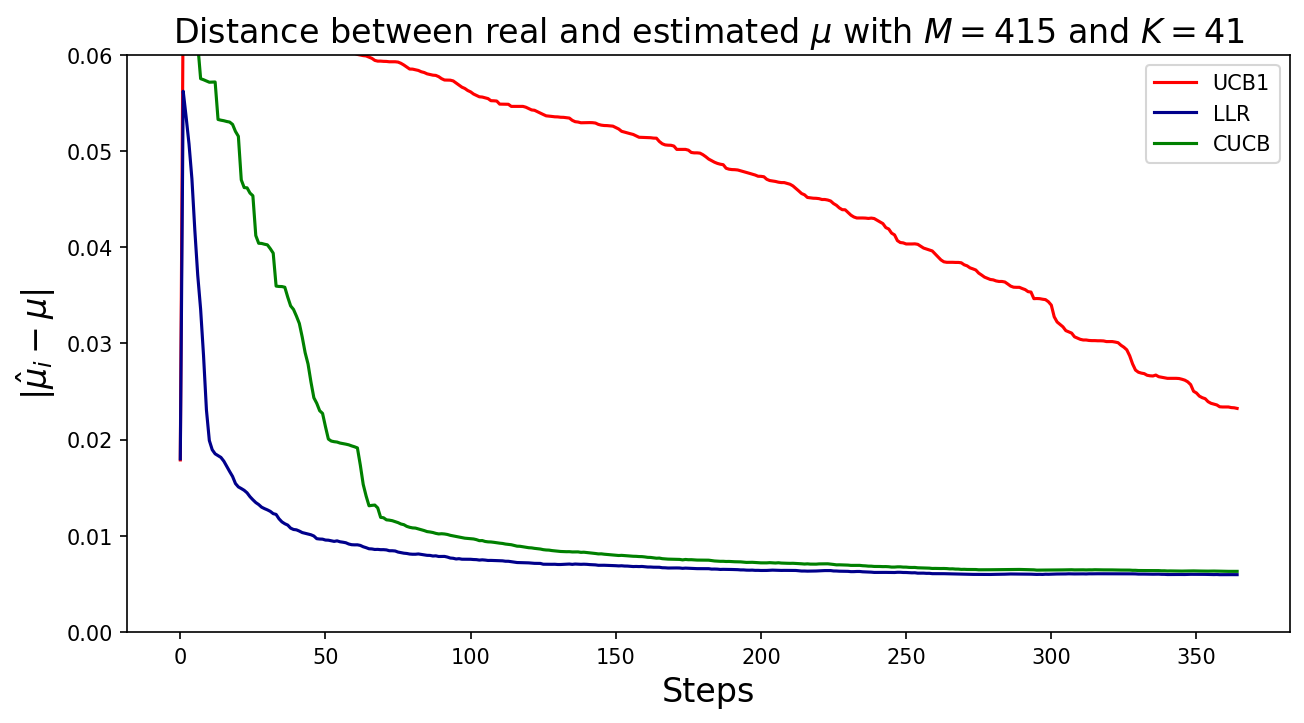

In [29]:
fig, ax = plt.subplots(figsize = (10, 5), dpi = 150)
distances_mu[["UCB1", "LLR", "CUCB"]].plot(ylim = (0, 0.06), color = ["red", "darkblue", "green"], ax = ax)
plt.ylabel(r'$|\hat \mu_i - \mu|$', fontsize = 16);
plt.xlabel(r'Steps', fontsize = 16);
plt.savefig("../../Outputs/Figures/figure_10_convergencia_global_mu2_notitulo.png")
plt.title(r'Distance between real and estimated $\mu$ with $M = {}$ and $K={}$'.format(M, K), fontsize = 16);
plt.savefig("../../Outputs/Figures/figure_10_convergencia_global_mu2.png")

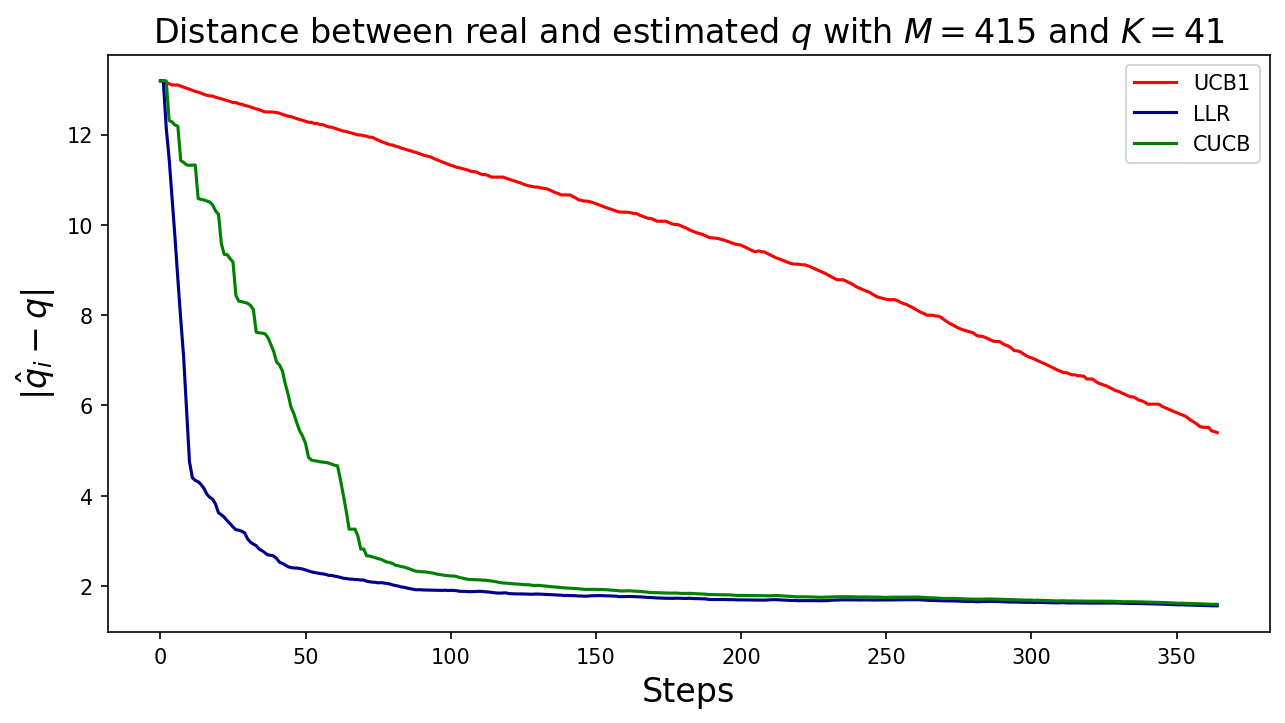

In [30]:
fig, ax = plt.subplots(figsize = (10, 5), dpi = 150)
distances_q[["UCB1", "LLR", "CUCB"]].plot(ax = ax, color = ["red", "darkblue", "green"])
plt.ylabel(r'$|\hat q_i - q|$', fontsize = 16);
plt.xlabel(r'Steps', fontsize = 16);
plt.savefig('../../Outputs/Figures/figure_11_convergencia_global_q2_notitulo.png')
plt.title(r'Distance between real and estimated $q$ with $M = {}$ and $K={}$'.format(M, K), fontsize=16);
plt.savefig('../../Outputs/Figures/figure_11_convergencia_global_q2.png')

In [31]:
mu_hat_final = pd.DataFrame({"celda": celdas, "m": mu_hat_final.m.unique()}).merge(
    mu_hat_final,
    how = "right"
)

In [32]:
convergencia_localidad = mu_hat_final.merge(diccionario_localidades, how = "left", on = "celda").groupby(["Localidad", "model", "t"]) \
    .value.mean().reset_index(name = "value")

In [33]:
rho_localidad = pd.DataFrame({"celda": celdas, "m": mu_hat_final.m.unique(), "rho": rho}) \
    .merge(diccionario_localidades, how = "left", on = "celda") \
        .groupby(["Localidad"]) \
            .rho.mean().reset_index(name = "rho")

In [34]:
underreporting = pd.concat([underreporting1, underreporting2, underreporting3]).reset_index(drop = True)
reporting = pd.concat([reporting1, reporting2, reporting3]).reset_index(drop = True)

In [35]:
underreport_real = preport.sum(axis = 0).mean()
report_real = report.sum(axis = 0).mean()

In [36]:
underreporting_m = underreporting.copy()
underreporting_m["underreporting"] = underreporting_m["underreporting"] * 30
reporting_m = reporting.copy()
reporting_m["reporting"] = reporting_m["underreporting"] * 30

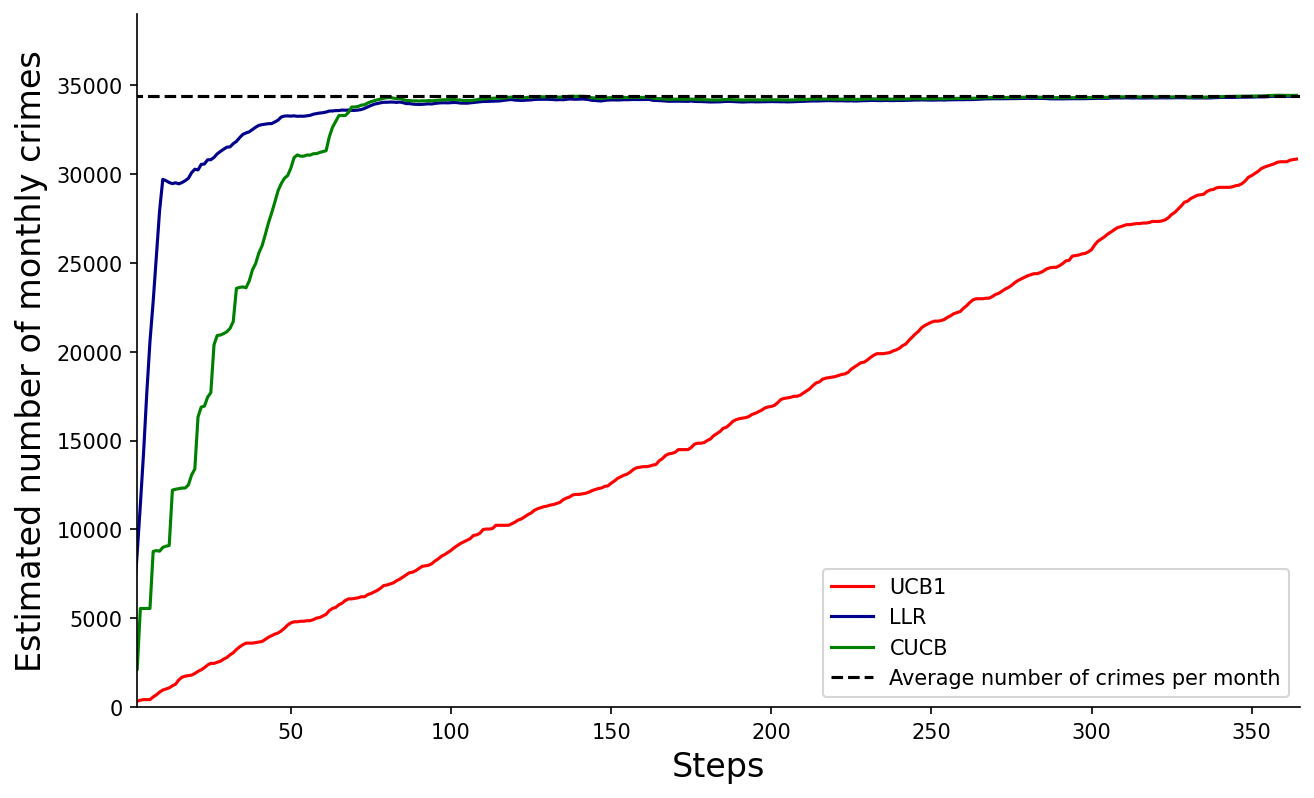

In [37]:
fig, ax = plt.subplots(figsize = (10, 6), dpi = 150)
sns.despine()
plt.ylim((0, 1300*30))
plt.xlim((2, 365))
sns.lineplot(data = reporting_m, x = "t", y = "reporting", hue = "algorithm", 
    palette = ["red", "darkblue", "green"], ax = ax)
plt.xlabel("Steps", fontsize=16)
plt.ylabel("Estimated number of monthly crimes", fontsize=16)
plt.hlines(y = report_real * 30, xmin = 0, xmax = T_max, 
        label = "Average number of crimes per month", 
        linestyles = "dashed", 
        colors = "black")
plt.legend(title = "")
plt.savefig('../../Outputs/Figures/figure_13_convergencia_global_reporte(Nxrho)_mensual.png')

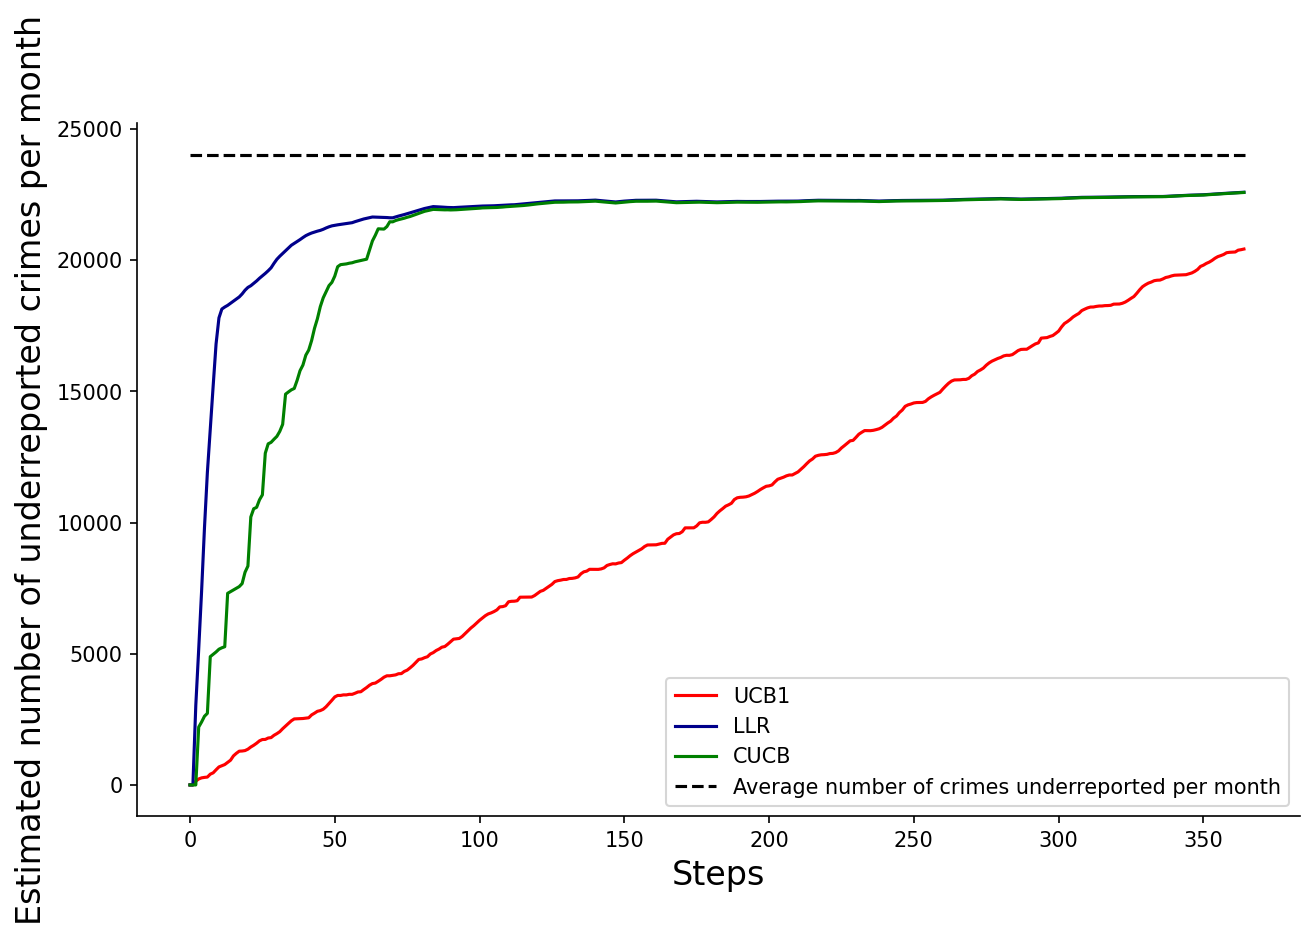

In [38]:
fig, ax = plt.subplots(figsize = (10, 6), dpi = 150)
sns.despine()
sns.lineplot(data = underreporting_m, x = "t", y = "underreporting", hue = "algorithm", 
    palette = ["red", "darkblue", "green"], ax = ax)
plt.xlabel("Steps", fontsize=16)
plt.ylabel("Estimated number of underreported crimes per month", fontsize=16)
plt.hlines(y = underreport_real * 30, xmin = 0, xmax = T_max, 
        label = "Average number of crimes underreported per month", 
        linestyles = "dashed", 
        colors = "black")
plt.legend(title = "")
plt.savefig('../../Outputs/Figures/figure_14_convergencia_global_subreporte(Nxqxrho)_mensual.png')

In [39]:
underreporting.to_csv('../../Outputs/Data/underreporting.csv', sep = ";", index = False)
reporting.to_csv('../../Outputs/Data/reporting.csv', sep = ";", index = False)

In [40]:
mu_hat_final.to_csv('../../Outputs/Data/mu_hat_final.csv', sep = ";", index = False)

In [41]:
rho = np.median(report, axis=1) / N
mu_real = pd.DataFrame({"m": range(0, len(rho)), "celda": celdas, "values": rho})

In [42]:
mu_real.to_csv('../../Outputs/Data/mu_real.csv', sep = ";", index = False)

In [ ]:
# End of the code